# Image SIFT / CNN features stuff

Classify using SIFT and then CNN as feature extractor also

In [1]:
import os
import sys
import json
import yaml
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data

- process columns to get categories as before

In [2]:
df = pd.read_csv("/kaggle/input/flipkart/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
get_main_category = lambda example: re.findall("^.+?(?= >>|$)", example)[0]

df["main_product_category"] = df["product_category_tree"].apply(get_main_category)

df["main_product_category"].value_counts()

main_product_category
["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: count, dtype: int64

In [5]:
# !!!!!! ah the remove the [" O_o
df["main_product_category"] = df["main_product_category"].apply(lambda example: example[2:])

df["main_product_category"].value_counts()

main_product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

# Open CV stuff and SIFT features


[https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)

## References / credit : following ressources lien

- tuto/webinaire OC : Weather firt analysis notebook


### Image info in dataframe

it is in the `image` column to get the JPG names

# Create category2id mapping

- done manually so it's clear what is the correspondence

In [6]:
category2id = {k:v
                 for k,v in zip(
                     set(df["main_product_category"].unique()),
                     range(7)
                 )
                }

df["category_id"] = df["main_product_category"].apply(lambda x: category2id[x])

df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,category_id
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,3
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,3
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,0


In [7]:
from os import listdir

path = "/kaggle/input/flipkart/Flipkart/Images"

list_photos = [file.lstrip('0') for file in listdir(path)]

print(len(list_photos))

1050


# Show examples of each label

In [8]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = df[df['main_product_category'] == name]['image']
    return list(list_image_name)

In [9]:
df['main_product_category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [10]:
"""
list_cloudy=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="cloudy"]
list_rain=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="rain"]
list_shine=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="shine"]
list_sunrise=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="sunrise"]
"""

list_home_furnishing = list(df[df['main_product_category'] == 'Home Furnishing']['image'])
list_baby_care = list(df[df['main_product_category'] == 'Baby Care']['image'])
list_watches = list(df[df['main_product_category'] == 'Watches']['image'])
list_home_decor = list(df[df['main_product_category'] == 'Home Decor & Festive Needs']['image'])
list_kitchen = list(df[df['main_product_category'] == 'Kitchen & Dining']['image'])
list_beauty = list(df[df['main_product_category'] == 'Beauty and Personal Care']['image'])
list_computers = list(df[df['main_product_category'] == 'Computers']['image'])

Displaying some examples from product category : Home Furnishing


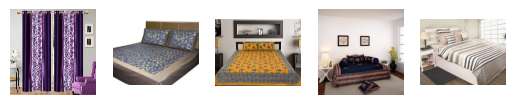

Displaying some examples from product category : Baby Care


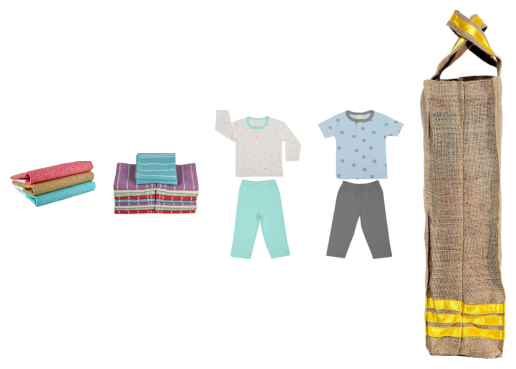

Displaying some examples from product category : Watches


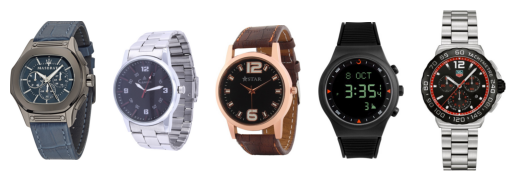

Displaying some examples from product category : Home Decor & Festive Needs


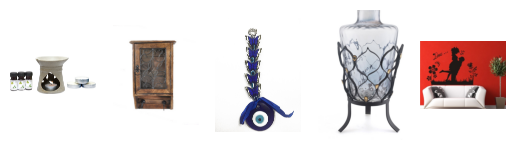

Displaying some examples from product category : Kitchen & Dining


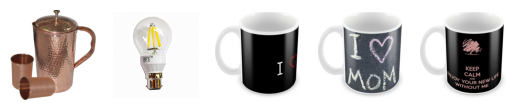

Displaying some examples from product category : Beauty and Personal Care


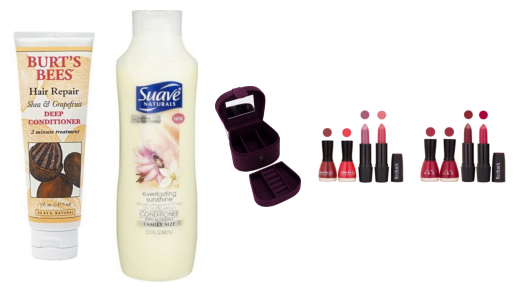

Displaying some examples from product category : Computers


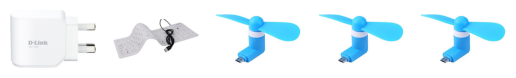

In [11]:
# "list labels" is the values possible for the product 
list_labels = list(df['main_product_category'].unique())

for name in list_labels:
    print(f"Displaying some examples from product category : {name}")
    # print("-------")
    for i in range(5):
        plt.subplot(1, 5, 1 + i)
        filename = os.path.join(path, list_fct(name)[i])
        image = imread(filename)
        plt.axis(False)
        plt.imshow(image)
    plt.show()

### Look at Computer example

- see picture above, the last 3 images seem identical but we found that there were no duplicates in text/descriptions !?

In [12]:
# seems that some images "reappear" even though descriptions are different???! ask mentor TODO
# - seems to be 3 "different" USB fans / accessories
df.loc[df["main_product_category"] == "Computers"][:5]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_product_category,category_id
47,d1899ab1d5c79ddaa311bc9f04d198ed,2016-03-20 14:44:44 +0000,http://www.flipkart.com/d-link-dap1320/p/itmeg...,D-Link DAP1320,"[""Computers >> Network Components >> Routers >...",RTREGG8F83DMYHPE,3500.0,1978.0,d1899ab1d5c79ddaa311bc9f04d198ed.jpg,False,"Key Features of D-Link DAP1320 QRS app(iOS,And...",No rating available,No rating available,D-Link,"{""product_specification""=>[{""key""=>""Wireless S...",Computers,5
51,b4d35b6536b623c83b293eb3a1c02bba,2016-03-20 14:44:44 +0000,http://www.flipkart.com/roq-slim-multimedia-10...,RoQ Slim Multimedia 105key Flexible Wired USB ...,"[""Computers >> Tablet Accessories >> Keyboards...",ACCEGYPGD9XH3RKR,999.0,399.0,b4d35b6536b623c83b293eb3a1c02bba.jpg,False,Key Features of RoQ Slim Multimedia 105key Fle...,No rating available,No rating available,RoQ,"{""product_specification""=>[{""key""=>""Interface""...",Computers,5
53,6329ddb46087cb8c09ced95471dd9643,2016-06-17 11:45:06 +0000,http://www.flipkart.com/jrb-1038-smallest-mobi...,JRB 1038 Smallest Mobile Powered By OTG Enable...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEJPQKBNS5KDTE,499.0,249.0,6329ddb46087cb8c09ced95471dd9643.jpg,False,Key Features of JRB 1038 Smallest Mobile Power...,No rating available,No rating available,JRB,"{""product_specification""=>nil}",Computers,5
54,7e6ae1b372e8e0b509b83ba3658b8107,2016-06-17 11:45:06 +0000,http://www.flipkart.com/jrb-1033-smallest-mobi...,JRB 1033 Smallest Mobile Powered By OTG Enable...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEJPQHFM7CVCYH,499.0,249.0,7e6ae1b372e8e0b509b83ba3658b8107.jpg,False,Key Features of JRB 1033 Smallest Mobile Power...,No rating available,No rating available,JRB,"{""product_specification""=>nil}",Computers,5
55,e2ae2af58ac50adf4881751ae84a9d8a,2016-06-17 11:45:06 +0000,http://www.flipkart.com/jrb-1042-smallest-mobi...,JRB 1042 Smallest Mobile Powered By OTG Enable...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEJPQHT8YPZ7D8,499.0,249.0,e2ae2af58ac50adf4881751ae84a9d8a.jpg,False,Key Features of JRB 1042 Smallest Mobile Power...,No rating available,No rating available,JRB,"{""product_specification""=>nil}",Computers,5


# Do one example of SIFT features

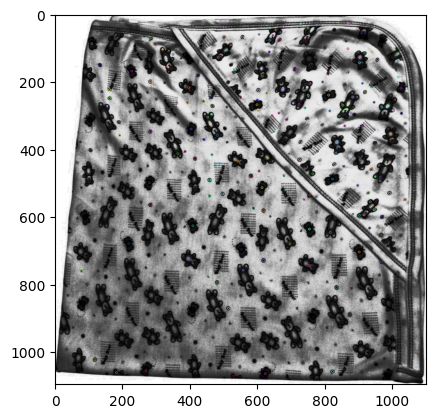

Descripteurs :  (400, 128)

[[78.  4.  1. ... 14.  2. 10.]
 [59.  1.  0. ...  1.  0.  1.]
 [ 6. 12.  3. ...  0.  0.  2.]
 ...
 [ 9.  8. 41. ...  0.  1.  4.]
 [ 2.  1.  0. ...  3.  0. 39.]
 [ 3.  0.  0. ...  1.  0.  1.]]


In [13]:
import cv2

#sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create(nfeatures=400) # TODO: add number of features?? I added 400 manualy as otherwise it was creating up to 15,000 O_O??? no answers on SO or docs

image = cv2.imread( os.path.join(path, list_photos[1]) , 0)

image = cv2.equalizeHist(image)   # equalize image histogram

kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

# SIFT preprocessing



In [14]:
# debuggin - trying to change load img as other one doesnt work O_o
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [15]:
# identification of key points and associated descriptors
import time

sift_keypoints = []
temps1=time.time()

#sift = cv2.xfeatures2d.SIFT_create(500)
sift = cv2.SIFT_create(nfeatures=500) # manually specified 500 as otherwise get 15k ++ O_o
#sift = cv2.SIFT_create()

TRY_RESIZE = False # todo: add to a function so can toggle easily if it's useful

for image_num in range(len(df)):
    if image_num % 20 == 0:
        print(image_num)
    
    image = cv2.imread(path + '/' + df['image'][image_num])
    
    try:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        res = cv2.equalizeHist(image)   # equalize image histogram
        
        # try resizing discu mentor
        if TRY_RESIZE:
            res = cv2.resize(res, (200, 200))
        
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)
    except Exception as e:
        print(e)
        print("CREATE DUMMY DESCRIPTION") # added during debug, seems depending on input processing you get some images with 0 SIFT features
        des = np.zeros((1, 128))
        sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object) # UPDATE - NEEDED TO ADD DTYPE=object ffs incomprehnsible debugging messagess in openCV
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040

Nombre de descripteurs :  (517304, 128)
temps de traitement SIFT descriptor :           539.73 secondes


# Clustering

In [16]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :             8.48 secondes


# Feature creation

In [17]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.11 secondes


# PCA and TSNE

update : bugfix after discussion mentor

In [18]:
im_features, im_features.shape

(array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.002, ..., 0.008, 0.   , 0.008],
        [0.006, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.008, 0.   ],
        [0.004, 0.   , 0.   , ..., 0.   , 0.004, 0.002],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]),
 (1050, 719))

In [19]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99) # ?????? bug here sometimes only get 1 dimension output???
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 500)


## ??? PCA reduces to 1 dimension ???

update - fixed ffs openCV is incomprehensible

In [20]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)

X_tsne = tsne.fit_transform(feat_pca) # update - PCA should work now, dims > 1 at last
#X_tsne = tsne.fit_transform(im_features) # fit the features directly, PCA is collapsing to 1 dimeniosn only O_o

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])

#df_tsne["class"] = data["label_name"]
df_tsne["class"] = df["main_product_category"]

print(df_tsne.shape)

(1050, 3)


# Plotting

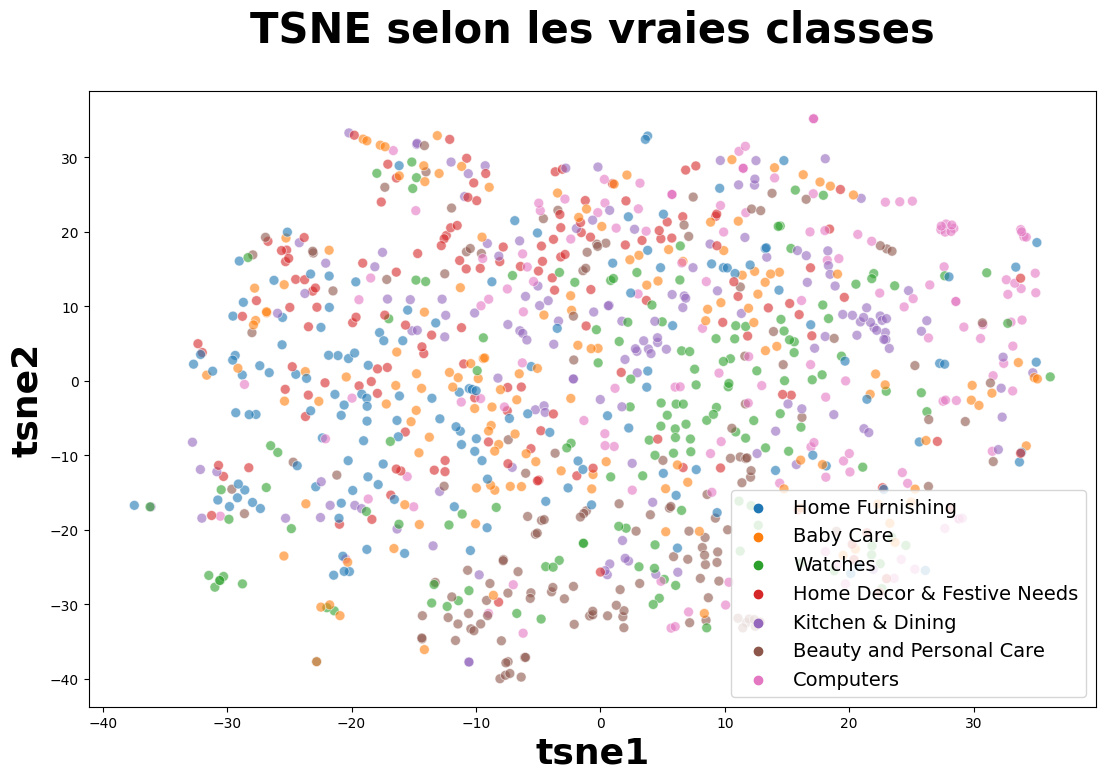

In [21]:
plt.figure(figsize=(13, 8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6) # care! change n_colors to match number of categories

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# Analysis of clusters according to actual classes

## Create clusters from TSNE

In [22]:
from sklearn import cluster, metrics

#cls = cluster.KMeans(n_clusters=4, random_state=6)

# we have 7 product categories
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


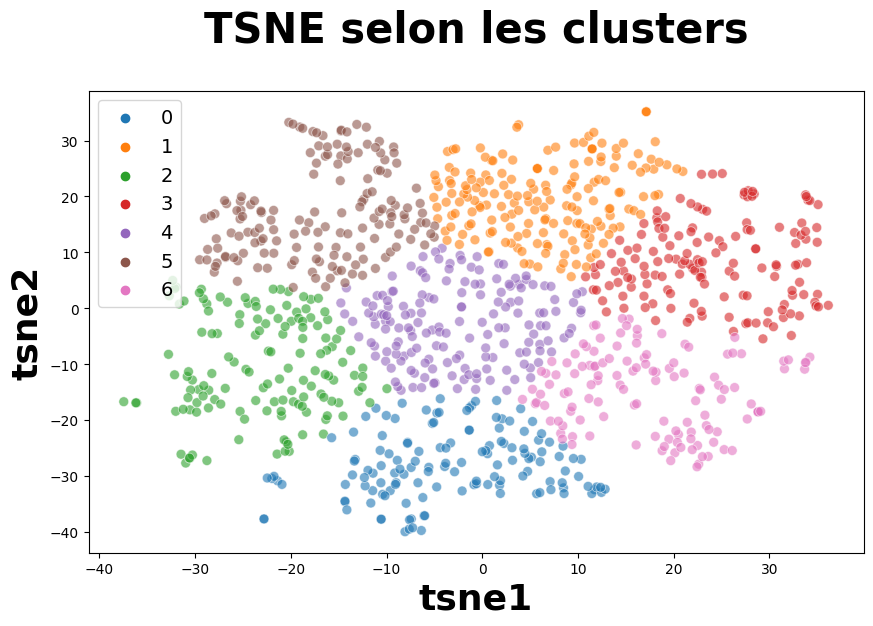

ARI :  0.06049293014040497


In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#labels = data["label"]
labels = df["main_product_category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [24]:
df_tsne.head(20)

,tsne1,tsne2,class,cluster
0,-22.876198,-14.230521,Home Furnishing,2
1,-22.627151,-2.767197,Baby Care,2
2,19.508448,-23.432379,Baby Care,6
3,-25.583261,4.826153,Home Furnishing,5
4,-22.344843,-7.673497,Home Furnishing,2
5,-30.982384,-27.703711,Watches,2
6,18.795378,-25.490700,Watches,6
7,-30.552290,-26.799463,Watches,2
8,-21.389648,-30.878590,Watches,0
9,-13.557850,-29.830694,Watches,0


In [26]:
df_tsne["cluster"].value_counts()

cluster
1    180
4    165
5    152
3    148
2    140
0    138
6    127
Name: count, dtype: int64

# Class level analysis

## Confusion matrix


In [27]:
df_tsne.groupby("cluster").count()["class"] # same as value counts, weird code from TP O_o

cluster
0    138
1    180
2    140
3    148
4    165
5    152
6    127
Name: class, dtype: int64

In [28]:
# Need to use the same numerical labels
numerical_labels = df["category_id"]

conf_mat = metrics.confusion_matrix(numerical_labels, cls.labels_)
print(conf_mat)

[[ 7 19 54 10 26 21 13]
 [27 16 16 25 35  9 22]
 [72 16  5 11  6 15 25]
 [ 9 32 19 14 36 23 17]
 [12 28 13 30 30 26 11]
 [ 9 33  8 50 14 11 25]
 [ 2 36 25  8 18 47 14]]


In [54]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    #corresp = np.argmax(conf_mat, axis=0)
    # !!!!! UPDATE -- quand on fait argmax on confond/reutilse 2 et 6 donc des colonnes sont vides
    # DONC ON AJUSTE A LA MAIN -> on attribue a la main 
    #corresp = [2, 6, 0, 5, 3, 6, 2] # <--- sortie avec argmax
    corresp = [2, 4, 0, 5, 3, 6, 1] # <--- sortie corrigee a la main
    
    
    print ("Correspondance des clusters : ", corresp)
    
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']
    #return labels['y_pred']

cls_labels_transform = conf_mat_transform(numerical_labels, cls.labels_)
conf_mat = metrics.confusion_matrix(numerical_labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(numerical_labels, cls_labels_transform))

Correspondance des clusters :  [2, 4, 0, 5, 3, 6, 1]
[[54 13  7 26 19 10 21]
 [16 22 27 35 16 25  9]
 [ 5 25 72  6 16 11 15]
 [19 17  9 36 32 14 23]
 [13 11 12 30 28 30 26]
 [ 8 25  9 14 33 50 11]
 [25 14  2 18 36  8 47]]

              precision    recall  f1-score   support

           0       0.39      0.36      0.37       150
           1       0.17      0.15      0.16       150
           2       0.52      0.48      0.50       150
           3       0.22      0.24      0.23       150
           4       0.16      0.19      0.17       150
           5       0.34      0.33      0.34       150
           6       0.31      0.31      0.31       150

    accuracy                           0.29      1050
   macro avg       0.30      0.29      0.30      1050
weighted avg       0.30      0.29      0.30      1050



<Axes: >

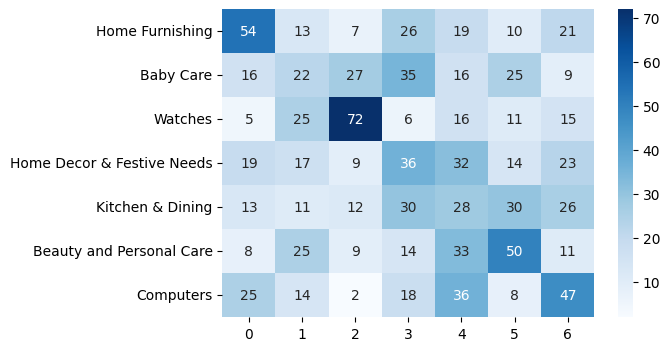

In [55]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Commentaires

- ARI de 0.06 pas bon du tout
- On voit que les watches sont OK, et aussi beaucoup moins le home furnishing/beauty/computers
- Pour les autres categories, les perfs ne sont pas bonnes du tout



# Part 2 - Classification avec CNN

- use last layer of CNN as features for images

In [58]:
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


# Create model

In [59]:
base_model = VGG16()

# removing the classifier head (after reading docs - wasn't clear from TP)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# Check / walkthrough a single example

- need to convert to 224x224 to match model input layer

In [66]:
TARGET_SIZE = (224, 224)

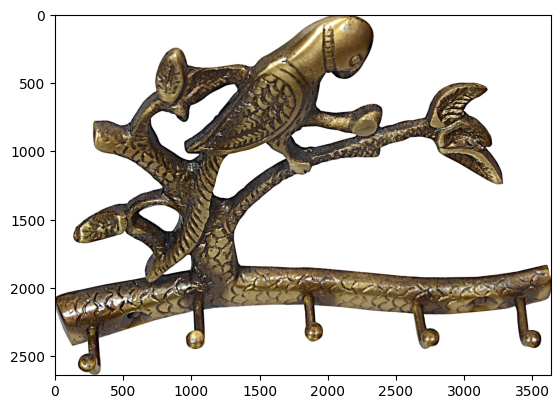

In [64]:
example_image_file = path + '/' + df["image"][123]

img = load_img(example_image_file)

plt.imshow(img)

### See how it looks in 224x224

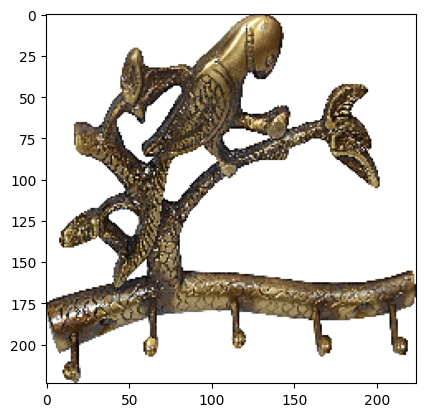

In [68]:
img_resized = load_img(example_image_file, target_size=TARGET_SIZE) 

plt.imshow(img_resized)

### Look at the neural net features obtained from such an image

In [70]:
image = img_to_array(img_resized) 
image = np.expand_dims(image, axis=0)
image_vgc_input = preprocess_input(image)

# CNN model features
image_vgc_features = model.predict(image_vgc_input)

image_vgc_features, image_vgc_features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (1, 4096))

In [74]:
np.count_nonzero(image_vgc_features) # just checking as it seems lots of 0 features O_o

908

# Apply CNN feature extractor for entire dataset

- above walkthrough makes sense so far

In [75]:
images_features = []

for image_num in range(len(df)):
    if image_num % 20 == 0:
        print(image_num)
    
    image = load_img(path + '/' + df['image'][image_num], target_size=TARGET_SIZE)
    
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040


(1050, 4096)

# PCA dimension reduction

In [76]:
cnn_pca = decomposition.PCA(n_components=0.99)
feat_cnn_pca= cnn_pca.fit_transform(images_features)
print(feat_cnn_pca.shape)

(1050, 803)


# TSNE

In [77]:
temps1 = time.time()

cnn_tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_cnn_tsne = cnn_tsne.fit_transform(feat_cnn_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            10.08 secondes


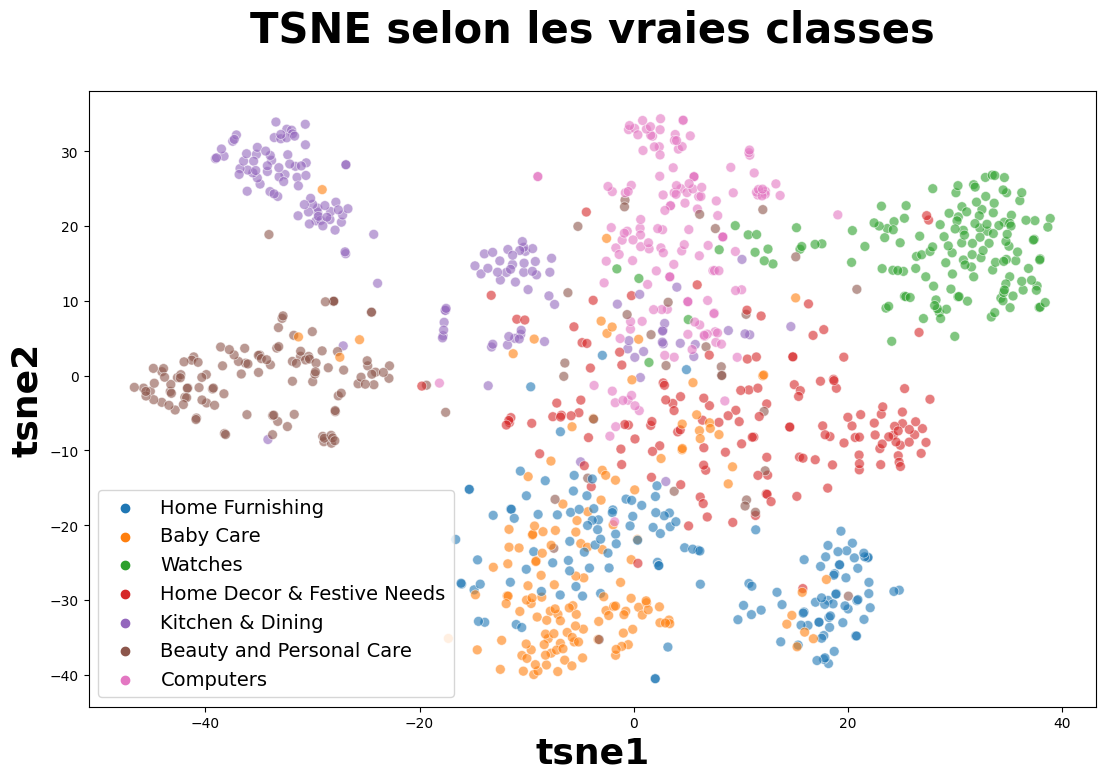

In [78]:
df_tsne = pd.DataFrame(X_cnn_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_product_category"]

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# Kmeans

In [79]:
cnn_cls = cluster.KMeans(n_clusters=7, n_init=100)
cnn_cls.fit(X_cnn_tsne)

KMeans(n_clusters=7, n_init=100)

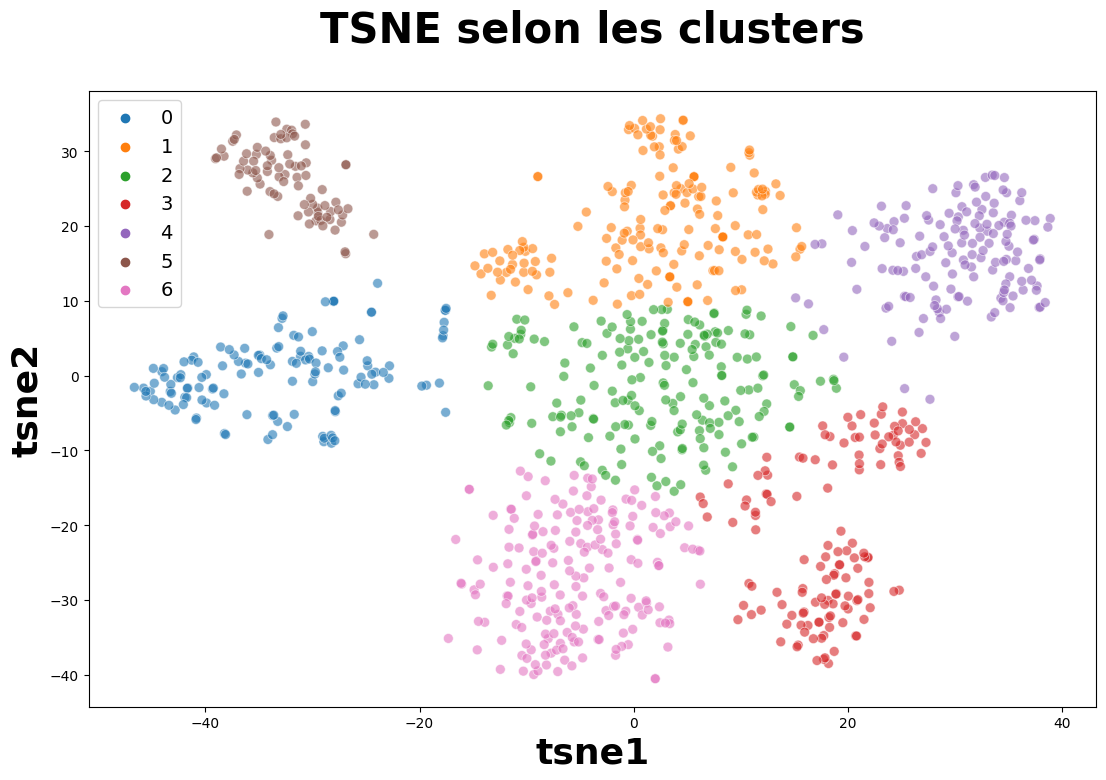

ARI :  0.45249599963484743


In [80]:
df_tsne["cluster"] = cnn_cls.labels_

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df["main_product_category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cnn_cls.labels_))

# Comments on CNN results

- here the ARI is good and the visual separation confirms (or vice versa O_o)
- we can expect good results if we train a classifier now